In [2]:
import cv2
import dlib
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
from deepface import DeepFace

In [3]:
# Let's make a function that detects the face, using the Dlib library methods.
# In addition, let's combine some of the functionality with cv2, so we can render the rectangles on people's faces
# that were detected.
#Lastly, after detecing the face, crop out the said face and process it through the FER to determine an emotion
def detectFaceDlib(detector, frame, data, inHeight=1650, inWidth=0):
    frameDlibHog = frame.copy()
    frameHeight = frameDlibHog.shape[0]
    frameWidth = frameDlibHog.shape[1]
    
    if not inWidth:
        inWidth = int((frameWidth / frameHeight) * inHeight)
    
    scaleHeight = frameHeight / inHeight
    scaleWidth = frameWidth / inWidth
    
    frameDlibHogSmall = cv2.resize(frameDlibHog, (inWidth, inHeight))
    faceRects = detector(frameDlibHogSmall, 0)
    print(frameWidth, frameHeight, inWidth, inHeight)
    bboxes = []
    
    for faceRect in faceRects:
        cvRect = [int(faceRect.left() * scaleWidth), int(faceRect.top() * scaleHeight), int(faceRect.right() * scaleWidth), int(faceRect.bottom() * scaleHeight)]
        bboxes.append(cvRect)
        cv2.rectangle(frameDlibHog, (cvRect[0], cvRect[1]), (cvRect[2], cvRect[3]), (0, 255, 0), int(round(frameHeight/250)), 4)    
    
    for i, d in enumerate(faceRects):
        crop = frameDlibHogSmall[d.top():d.bottom(), d.left():d.right()]
        result = DeepFace.analyze(crop, actions = ['emotion'], enforce_detection =  False)
        if(result['dominant_emotion'] == 'neutral'):
            data[0] += 1
        elif(result['dominant_emotion'] == 'angry'):
            data[1] += 1
        elif(result['dominant_emotion'] == 'disgust'):
            data[2] += 1
        elif(result['dominant_emotion'] == 'fear'):
            data[3] += 1
        elif(result['dominant_emotion'] == 'happy'):
            data[4] += 1
        elif(result['dominant_emotion'] == 'sad'):
            data[5] += 1
        elif(result['dominant_emotion'] == 'surprise'):
            data[6] += 1
            
    return frameDlibHog, bboxes

In [4]:
# If we want very high accuracy on facial recognition, keep the input height above 700.
# However, the only downside of having high accuracy for facial recognition is low framerate.
# If we want low accuracy but high framerate, then lower the input height below 500.
# Expect the software to have issues when analyzing faces that are below 100 or so pixels.
# It is typically accurate when the pixels are NOT below 100 pixels; otherwise, expect small frames to not be captured.

# In addition, the individual needs to look at the camera for the software to recognize their face.
# Otherwise, if they are NOT looking at the camera, their face will not be read.

# Take aways
# 1. higher facial detection accuracy = slower run-time.
# 2. lower facial detection accuracy = faster run-time.
# 3. If the lighting is bad, the face will not be read.
# 4. If the frame is simply too small (less than 100 pixels), then expect the face to not be read.
# 5. HOG outperforms MMOD in every way, including accuracy. It also doesn't need a .dat library.
# 6. 1200 for input height seems to be the sweet spot.

1280 720 2933 1650
1280 720 2933 1650
1280 720 2933 1650
1280 720 2933 1650
1280 720 2933 1650
1280 720 2933 1650
1280 720 2933 1650
1280 720 2933 1650
1280 720 2933 1650
1280 720 2933 1650
1280 720 2933 1650
1280 720 2933 1650
1280 720 2933 1650
1280 720 2933 1650
1280 720 2933 1650
1280 720 2933 1650
1280 720 2933 1650


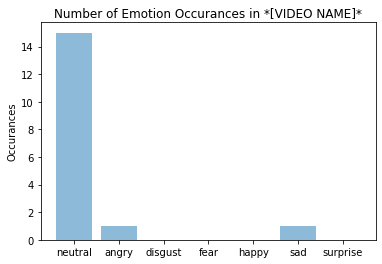

In [5]:
if __name__ == '__main__':
    data = [0, 0, 0, 0, 0, 0, 0]
    
    hogFaceDetector = dlib.get_frontal_face_detector()
    
    source = '00002.mp4' # File path a video here, it can be only accept one file as it should.
    
    cap = cv2.VideoCapture(source)
    hasFrame, frame = cap.read()
    
    vid_writer = cv2.VideoWriter('output-hog-{}.avi'.format(str(source).split(".")[0]), cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), 15, (frame.shape[1], frame.shape[0])) #Output the results onto a video.
    
    frame_count = 0 # We need a frame counter.
    tt_dlibHog = 0
    
    while(1):
        hasFrame, frame = cap.read()
        
        if not hasFrame:
            break
            
        frame_count += 1
        
        t = time.time()
        
        outDlibHog, bboxes = detectFaceDlib(hogFaceDetector, frame, data)
                
        tt_dlibHog += time.time()  - t
        fpsDlibHog = frame_count / tt_dlibHog
        
        label = "DLIB HoG ; FPS : {:.2f}".format(fpsDlibHog)
        cv2.putText(outDlibHog, label, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.4, (0, 0, 255), 3, cv2.LINE_AA)
    
        
        cv2.imshow("Face Detection Comparison", outDlibHog)

        vid_writer.write(outDlibHog)
        if frame_count == 1:
            tt_dlibHog = 0

        k = cv2.waitKey(1)
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break
            
    # When the program is finished analyzing the video (or the user quits analyzing by pressing 'Q'), output the results.
    emotions = ('neutral', 'angry', 'disgust', 'fear', 'happy', 'sad', 'surprise')
    y_pos = np.arange(len(emotions))
    plt.bar(y_pos, data, align ='center', alpha = .5)
    plt.xticks(y_pos, emotions)
    plt.ylabel('Occurances')
    plt.title('Number of Emotion Occurances in the anaylzed video')
    plt.show()
    
    cv2.destroyAllWindows()
    vid_writer.release()